Так, в темплейте какая-то магия происходила, матплотлиб выдавал пирожок с ничем, так что домашка тут

In [1]:
import cv2
import matplotlib.pylab as plt
import numpy as np
import seaborn as sns
sns.set()
import os
import torch 
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms as T

%matplotlib inline
plt.style.use('default')
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
COCO_INSTANCE_CATEGORY_NAMES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
# COCO_INSTANCE_CATEGORY_NAMES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', ]

In [3]:
class MyDataset(Dataset):
    def __init__(self, path_to_dataset):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
    
    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        return path
    
    def __len__(self):
        return len(self.photo_names)


def grid(array, ncols=3):  
    # https://stackoverflow.com/questions/42040747/more-idiomatic-way-to-display-images-in-a-grid-with-numpy
    nindex, height, width, intensity = array.shape
    nrows = nindex // ncols
    return (array.reshape(nrows, ncols, height, width, intensity).swapaxes(1,2).reshape(height*nrows, width*ncols, intensity))


def show(img, size=3):
    plt.figure(figsize=(size, size))
    ax = plt.axes([0, 0, 1, 1], frameon=False)
    ax.set_axis_off()
    plt.imshow(img)

TRANSFORM = T.ToTensor()
def get_prediction(img_path, model, threshold):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    img = TRANSFORM(img).to(device)
    pred = model([img])
    pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1]
    pred_boxes = pred_boxes[:pred_t + 1]
    pred_class = pred_class[:pred_t + 1]
    return pred_boxes, pred_class


def object_detection(img_path, model, threshold=0.5, rect_th=3, text_size=2, text_th=2):
    boxes, pred_cls = get_prediction(img_path, model, threshold)
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    for i in range(len(boxes)):
        cv2.rectangle(img,
                      boxes[i][0],
                      boxes[i][1],
                      color=(0, 255, 0),
                      thickness=rect_th)
        cv2.putText(img,
                    pred_cls[i],
                    boxes[i][0],
                    cv2.FONT_HERSHEY_SIMPLEX,
                    text_size,
                    (0, 255, 0),
                    thickness=text_th)
    return img

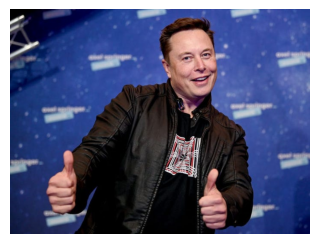

In [4]:
show(cv2.cvtColor(cv2.imread("elon_thumbs.jpeg"), cv2.COLOR_BGR2RGB))

Вы решили создать свою Self-Driving-Cars компанию.

Одной из самых главных задач в данном случае  -- это определять, что находится вокруг машины. Для этого необходимо применить методы компьютерного зрения, а именно решить задачу Object Detection. 

Измерьте качество определения объектов по датасету:

https://bdd-data.berkeley.edu/

с помощью двух алгоритмов и сравните их качество.

***1. (10 баллов)*** 

***Работа с алгоритмами***: Примените оба алгоритма:

* одна из версий YOLO
* Faster R-CNN(любой, который будет удобен Вам в использовании)

и выведете результаты детекции для первых 20 изображений. 

В качестве ответа на это задание ожидается:

* код с помощью которого осуществляется само детектирование или код обращения к фреймворкам для детектирования;
* 20 изображений в ноутбуке, на которых в произвели детекцию;

In [5]:
dset = MyDataset("archive/bdd100k/bdd100k/images/10k/train/")

In [6]:
yolo_model = torch.hub.load('ultralytics/yolov5', 'yolov5s').to(device)

frcnn_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
frcnn_model.eval();

Using cache found in /home/breengles/.cache/torch/hub/ultralytics_yolov5_master
Fusing layers... 
Model Summary: 224 layers, 7266973 parameters, 0 gradients
Adding autoShape... 
YOLOv5 🚀 2021-5-13 torch 1.8.1+cu102 CUDA:0 (NVIDIA GeForce RTX 2070 SUPER, 7973.9375MB)



In [7]:
yolo = []
frcnn = []

for idx, im in enumerate(dset):
    if idx == 20:
        break
    yolo.append(yolo_model(im).render()[0])
    frcnn.append(object_detection(im, frcnn_model, 0.55))

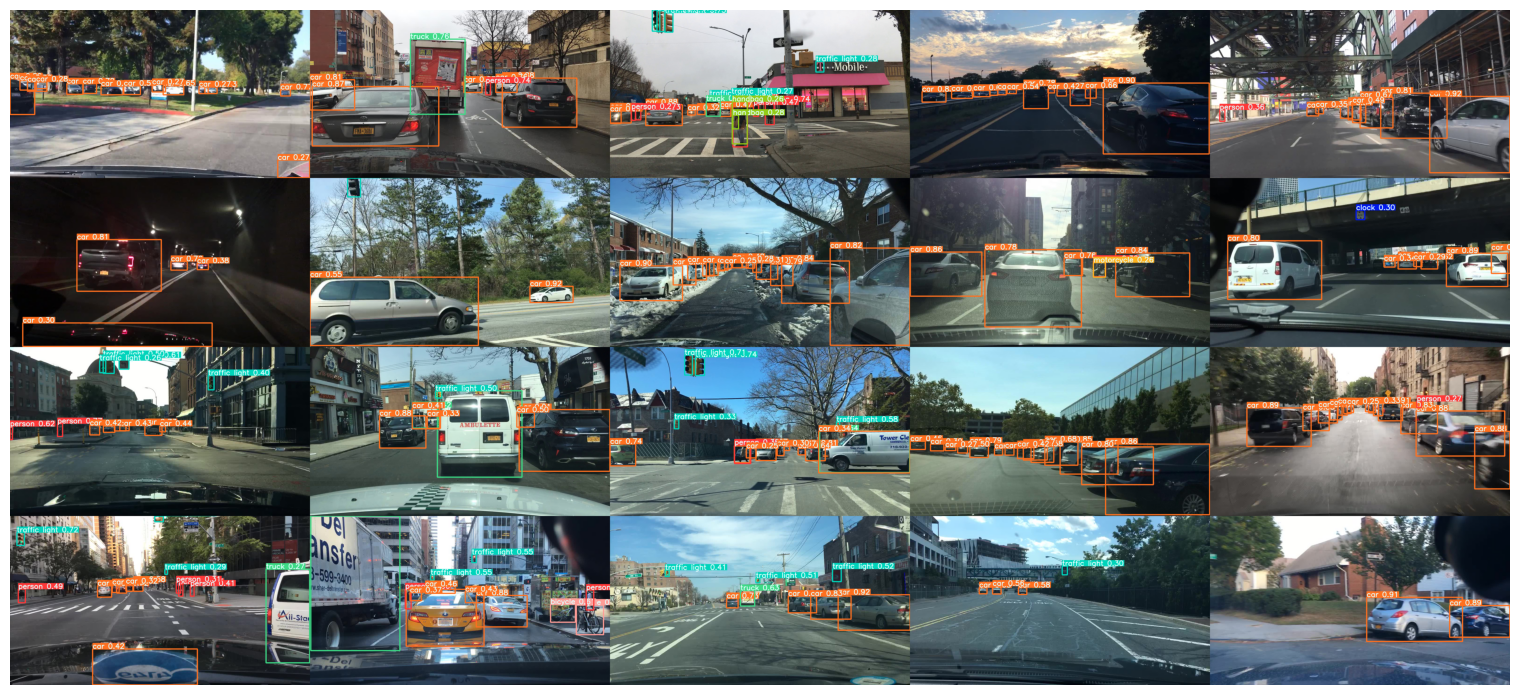

In [8]:
show(grid(np.array(yolo), 5), 15)

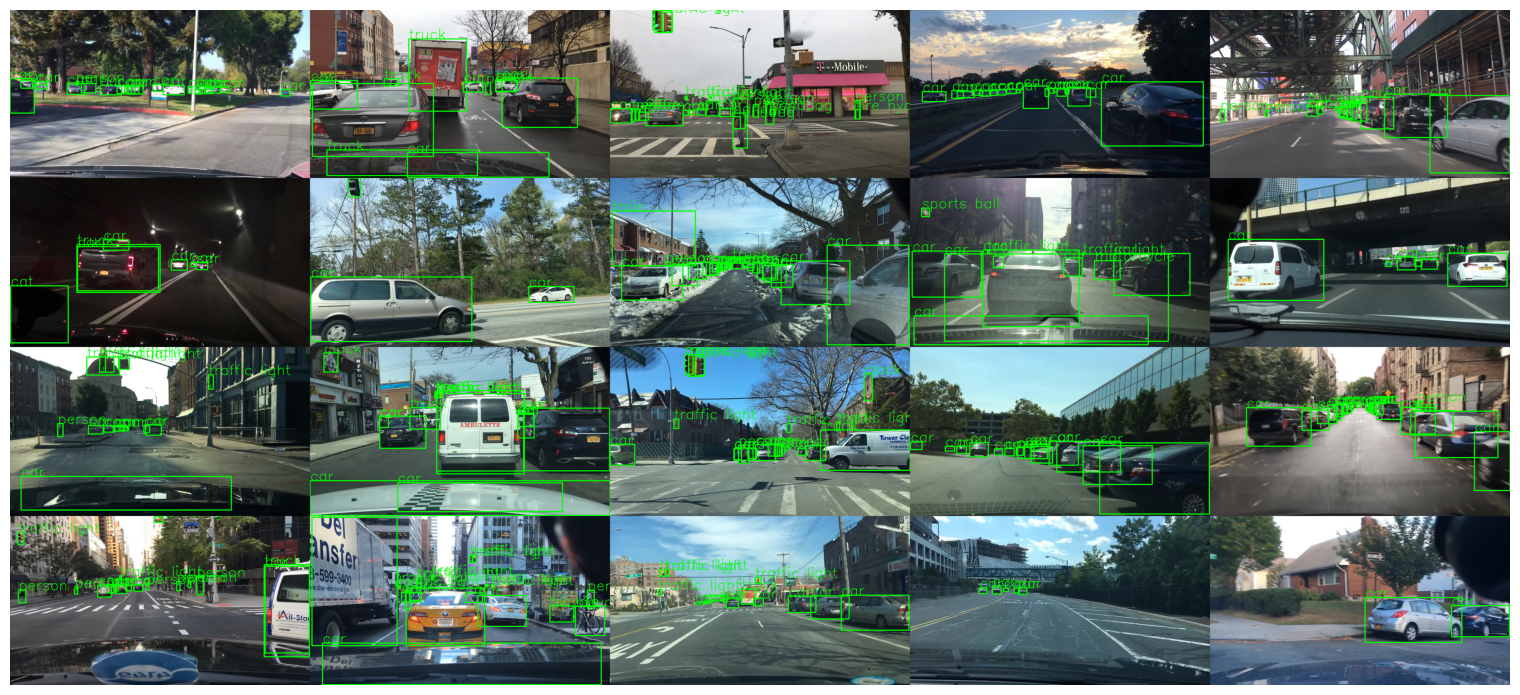

In [9]:
show(grid(np.array(frcnn), 5), 15)

***2. (10 баллов)***  Проведите сравнение двух рассмотренных алгоритмов с помощью метрик:

В качестве метрик сравнений предлагаются: 

* Detection Rate;
* mAP; 

все метрики для IoU > 0.5

В качестве справки: https://pdfs.semanticscholar.org/d051/ba0a904e4b4c45a2af145aa29b8490bbbc5c.pdf

Всё прошло довольно неплохо и Ваши старания дали плоды. 

Но для улучшения результата Вам нужно собрать данные, оборудование и набрать команду разработчиков. А для этого нужны инвестиции. 

Для привлечения внимания сторонних инвесторов, предлагается пригласить Илона на открытие Вашего первого офиса. Но из короновирусных ограничений Илон не сможет прилететь. А фотография с ним Вам очень нужна. 

***3. (10 баллов)*** Помогите Илону оказаться в Северной столице. Возьмите фото из приложения к домашнему заданию и перместите миллиардера и филантропа на улицу СПБ. Сделайте это двумя способами:

* напрямую методами opencv -- без сегментации;
* с помощью сегментации двумя методами:
        - grabcut;
        - mask r-cnn(например из detectron-a)